Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [613]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import networkx as nx
from icecream import ic
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate
from dataclasses import dataclass

#logging.basicConfig(level=logging.DEBUG)

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [614]:
#CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])
CITIES.head(10)

,name,lat,lon
0,Ancona,43.60,13.50
1,Andria,41.23,16.29
2,Bari,41.12,16.87
3,Bergamo,45.70,9.67
4,Bologna,44.50,11.34
5,Bolzano,46.50,11.35
6,Brescia,45.55,10.22
7,Cagliari,39.22,9.10
8,Catania,37.50,15.08
9,Ferrara,44.84,11.61


In [615]:
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

In [616]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

Professor's solution, start from the first city and go to the nearest one, iterate until we visit all the cities. Then we close the cycle by returning to the first city.

In [617]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp = list()
tsp.append(int(city))
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    visited[closest] = True
    city = closest
    tsp.append(int(city))
tsp.append(tsp[0])
f"Number of steps: {len(tsp)-1}, total length {tsp_cost(tsp):.2f}km"

'Number of steps: 46, total length 4436.03km'

## Second Greedy Algorithm

Professor's solution, idea for a new type of approach to the problem

In [618]:
def cyclic(edges):
    G = nx.Graps()
    edges = [list(e) for e, _ in edges]
    G.add_edge_from(edges)
    try:
        nx.find_cycle(G)
        return True
    except:
        return False

In [619]:
segments = [({c1, c2}, float(DIST_MATRIX[c1, c2])) for c1, c2 in combinations(range(len(CITIES)), 2)] #[({c1, c2}, len)]
visited = set()
edges = set()

shortest = next(_ for _ in sorted(segments, key=lambda e: e[1]))
visited |= shortest[0]
#edges |= {tuple(shortest[0])}
#segments = [s for s in segments if not cyclic(edges | {tuple(s[0])})]


## HC

This solutions is not good both in terms of number of steps and cost of the solution, using insert_mutation (minimize changes in the order) improves performance slightly compared to using swap_mutation

In [620]:
def swap_mutation(tsp: list):
    new_tsp = tsp.copy()
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    new_tsp[pos1] = tsp[pos2]
    new_tsp[pos2] = tsp[pos1]
    return new_tsp

def insert_mutation(tsp: list):
    new_tsp = tsp.copy()
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    if pos1 > pos2:
        temp = pos1
        pos1 = pos2
        pos2 = temp
    x = pos2
    while pos1 != pos2:
        pos1 += 1
        new_tsp[pos1] = tsp[x]
        x = pos1
    return new_tsp

def fitness(tsp: list):
    f_tsp = tsp.copy()
    f_tsp.append(tsp[0])
    return -float(tsp_cost(f_tsp))

  0%|          | 0/30000 [00:00<?, ?it/s]

'Number of steps: 30000, total length 5310.27km'

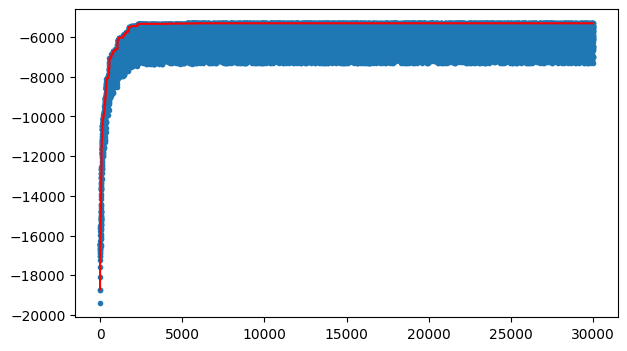

In [ ]:
#generate a solution that does not return to the initial city
tsp = list()
for i in range(0, len(CITIES)):
    tsp.append(int(i))
#HC
f_tsp = fitness(tsp)
history = [fitness(tsp)]
for steps in tqdm(range(10000)):
    new_tsp = insert_mutation(tsp)
    f = fitness(new_tsp)
    history.append(f)
    if f > f_tsp:
        tsp = new_tsp
        f_tsp = fitness(tsp)
tsp.append(tsp[0])
plt.figure(figsize=(7, 4))
plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
_ = plt.scatter(range(len(history)), history, marker=".")
f"Number of steps: {steps+1}, total length {tsp_cost(tsp):.2f}km"

## Simulated Annealing

  0%|          | 0/10000 [00:00<?, ?it/s]

'Number of steps: 1714, total length 6500.37km'

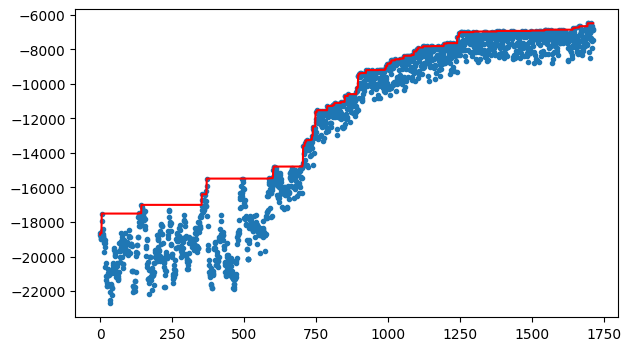

In [627]:
temp=300
cooling_rate=0.99
#generate a solution that does not return to the initial city
tsp = list()
for i in range(0, len(CITIES)):
    tsp.append(int(i))
f_tsp = fitness(tsp)
history = [fitness(tsp)]
for steps in tqdm(range(10000)):
    new_tsp = insert_mutation(tsp)
    f = fitness(new_tsp)
    history.append(f)
    delta_fitness = f - f_tsp
    # Acceptance criterion: accept if the new solution has better fitness, or probabilistically if worse
    if delta_fitness > 0 or np.random.randint(0, 1) < np.exp(delta_fitness / temp):
        tsp = new_tsp
        f_tsp = f
    temp *= cooling_rate
    if temp < 1e-5:
        break
tsp.append(tsp[0])
plt.figure(figsize=(7, 4))
plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
_ = plt.scatter(range(len(history)), history, marker=".")
f"Number of steps: {steps+1}, total length {tsp_cost(tsp):.2f}km"


## EA

EA with cycle crossover and insert mutation with an HYPERMODERN model

In [623]:
@dataclass
class Individual:
    genome: list
    fitness: float = None

def fitnessEA(individual: Individual):
    f_tsp = individual.genome.copy()
    f_tsp.append(individual.genome[0])
    return -float(tsp_cost(f_tsp))

def parent_selection(population):
    candidates = sorted(np.random.choice(population, 2), key=lambda e: e.fitness, reverse = True)
    return candidates[0]

def xover(p1: Individual, p2: Individual):
    sol = [-1 for _ in range(len(CITIES))]
    #cycle crossover
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    if pos1 > pos2:
        temp = pos1
        pos1 = pos2
        pos2 = temp
    mancanti = p2.genome.copy()
    for x in range(pos1, pos2):
        sol[x] = p1.genome[x]
        mancanti.remove(sol[x])
    for x in range(len(CITIES)):
        if sol[x] == -1:
            sol[x] = mancanti.pop(-1)
    return Individual(sol)

def mutation(p: Individual):
    #insert_mutation
    return Individual(insert_mutation(p.genome))

POPULATION_SIZE = 10
OFFSPRING_SIZE = 4
MAX_GENERATIONS = 5000

#genero la popolazione iniziale
population = list()
i = list(range(len(CITIES)))
for _ in range(POPULATION_SIZE):
    i = list(range(len(CITIES)))
    np.random.shuffle(i)
    population.append(Individual(i))
for i in population:
    i.fitness = fitnessEA(i)
population.sort(key=lambda i: i.fitness, reverse = True)
#HYPERMODERN
for g in tqdm(range(MAX_GENERATIONS)):
    #genero gli offspring
    offspring = []
    for _ in range(OFFSPRING_SIZE):
        if np.random.random() < 0.3:
            #mutation
            p = parent_selection(population)
            o = mutation(p)
        else:
            #crossover
            i1 = parent_selection(population)
            i2 = parent_selection(population)
            o = xover(i1, i2)
        offspring.append(o)
    #valuto il genome calcolando fitness
    for i in offspring:
        i.fitness = fitnessEA(i)
    #reinserisco gli offspring nella popolazione e tengo solo i primi POPULATION_SIZE individui
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse = True)
    population = population[:POPULATION_SIZE]
f"Number of generations: {g+1}, total length {-population[0].fitness:.2f}km"

  0%|          | 0/5000 [00:00<?, ?it/s]

'Number of generations: 5000, total length 4707.16km'

## Third Greedy Algorithm

I take a city at random and the city furthest from it, based on the straight line passing between the two positions I separate the other cities, then on the two sets I take the closest city 
to the previous one starting from the first city I take (it works well if the cities are arranged in a ring)

In [624]:
initialCity = np.random.randint(0, len(CITIES))
furthestCity = np.argmax(DIST_MATRIX[initialCity])
#calcolo retta
m = float((CITIES["lon"][furthestCity] - CITIES["lon"][initialCity])/(CITIES["lat"][furthestCity] - CITIES["lat"][initialCity]))
q = float(CITIES["lon"][initialCity]- (m * CITIES["lat"][initialCity]))
tsp_l = list()
tsp_r = list()
for x in range(len(CITIES)):
    if x != initialCity:
        if ((m * CITIES["lat"][x] + q - CITIES["lon"][x]) >= 0) or x == furthestCity:
            tsp_l.append(x)
        else:
            tsp_r.append(x)
#parte sinistra
city = initialCity
tsp = list()
tsp.append(int(city))
for x in range(1, len(tsp_l)+1):
    min = 10000
    minCity = city
    for y in tsp_l:
        if DIST_MATRIX[city][y] < min:
            min = DIST_MATRIX[city][y]
            minCity = y
    tsp_l.remove(minCity)
    city = minCity
    tsp.append(int(city))
#parte destra
for x in range(len(tsp_r)):
    min = 10000
    minCity = city
    for y in tsp_r:
        if DIST_MATRIX[city][y] < min:
            min = DIST_MATRIX[city][y]
            minCity = y
    tsp_r.remove(minCity)
    city = minCity
    tsp.append(int(city))
tsp.append(int(initialCity))
f"Number of steps: {(len(tsp)-1)*2}, total length {tsp_cost(tsp):.2f}km"

'Number of steps: 92, total length 4945.15km'

### sources
- prof example
- past exercises
- slides